In [1]:
%cd ..

E:\annotation_app


In [2]:
import sys
sys.path.append("backends/pysot")

In [3]:
import os
from argparse import Namespace

In [4]:
import cv2
import torch
import numpy as np
from glob import glob
from pathlib import Path

In [5]:
from image_array import MovieImageArray

In [6]:
from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker

## Modelのコンストラクト 

In [7]:
cfgarg = Namespace(config="backends/pysot/experiments/siamrpn_mobilev2_l234_dwxcorr/config.yaml",
                   snapshot="backends/pysot/experiments/siamrpn_mobilev2_l234_dwxcorr/model.pth",
                  )

In [8]:
cfg.merge_from_file(cfgarg.config)
cfg.CUDA = torch.cuda.is_available() and cfg.CUDA
device = torch.device("cpu")

In [9]:
model = ModelBuilder()

In [10]:
model.load_state_dict(torch.load(cfgarg.snapshot,
    map_location=lambda storage, loc: storage.cpu()))

<All keys matched successfully>

In [11]:
model.eval().to(device)
tracker = build_tracker(model)

## 動画の読み込み 

In [12]:
movie_path = Path("sample_movie/sample_movie_1.mp4")
temp_path = Path("temp")
image_array = MovieImageArray(movie_path, is_temp=False, temp_dir=temp_path)

In [13]:
image_array.read_movie(is_update=False)

## 最初の矩形 

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

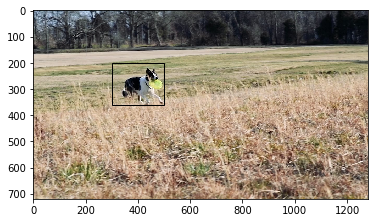

In [35]:
fig, ax = plt.subplots()

x1 = 300
y1 = 200
x2 = 500
y2 = 360

w = x2 - x1
h = y2 - y1

ax.imshow(image_array[0][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)

In [36]:
tracker.init(image_array[0], (x1,y1,w,h))

## 次の矩形を予測 

In [37]:
outputs = tracker.track(image_array[1])

In [38]:
outputs

{'bbox': [314.2358133649236,
  208.50278367952524,
  198.56202843677875,
  159.0886175164378],
 'best_score': 0.99965286}

In [39]:
x1 = outputs["bbox"][0]
y1 = outputs["bbox"][1]
w = outputs["bbox"][2]
h = outputs["bbox"][3]

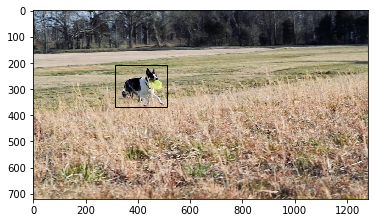

In [40]:
fig, ax = plt.subplots()

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)

### SiamRPNTracker 

In [41]:
class SiamRPNTrackerV2:
    def __init__(self, is_cpu=True):
        is_cpu = not torch.cuda.is_available() and is_cpu
        cfgarg = Namespace(config="backends/pysot/experiments/siamrpn_mobilev2_l234_dwxcorr/config.yaml",
                           snapshot="backends/pysot/experiments/siamrpn_mobilev2_l234_dwxcorr/model.pth",
                          )
        cfg.merge_from_file(cfgarg.config)
        cfg.CUDA = not is_cpu
        device = torch.device("cuda" if not is_cpu else "cpu")
        model = ModelBuilder()
        model.load_state_dict(torch.load(cfgarg.snapshot,
                              map_location=lambda storage, loc: storage.cpu()))
        model.eval().to(device)
        self.tracker = build_tracker(model)
        
    def set_bbox(self, image, xyxy_dict=None, polygon_list=None):
        if xyxy_dict is None:
            raise Exception("SiameseMaskTracker set_bbox need xyxy_dict")
        x1 = xyxy_dict["x1"]
        y1 = xyxy_dict["y1"]
        x2 = xyxy_dict["x2"]
        y2 = xyxy_dict["y2"]
        w = x2-x1
        h = y2-y1
        
        self.tracker.init(image, (x1,y1,w,h))
        
    def get_bbox(self, image):
        outputs = self.tracker.track(image)
        
        xyxy_dict = {"x1":int(outputs["bbox"][0]),
                     "y1":int(outputs["bbox"][1]),
                     "x2":int(outputs["bbox"][0]+outputs["bbox"][2]),
                     "y2":int(outputs["bbox"][1]+outputs["bbox"][3])
                    }
        
        out_dict = {"bbox_dict":xyxy_dict, "polygon":None}
        return out_dict

In [42]:
box_tracker = SiamRPNTrackerV2()

In [43]:
x1 = 300
y1 = 200
x2 = 500
y2 = 360
xyxy_dict = {"x1":x1, "y1":y1, "x2":x2, "y2":y2}

In [44]:
box_tracker.set_bbox(image_array[0], xyxy_dict)

In [45]:
out_dict = box_tracker.get_bbox(image_array[1])

In [46]:
out_dict

{'bbox_dict': {'x1': 314, 'y1': 208, 'x2': 512, 'y2': 367}, 'polygon': None}

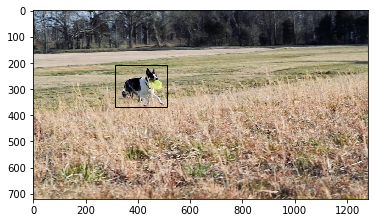

In [47]:
fig, ax = plt.subplots()

pos_dict = out_dict["bbox_dict"]
x1,y1,x2,y2 = pos_dict["x1"], pos_dict["y1"], pos_dict["x2"], pos_dict["y2"]

w = x2 - x1
h = y2 - y1


ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)